Note: need to start viewer with
```
jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
```
To avoid visualization data rate error [see this issue](--NotebookApp.iopub_data_rate_limit=1.0e10)

In [1]:
from itkwidgets import view
import itk
import numpy as np
import time
import matplotlib.pyplot as plt

Note: It seems I have to import and initialize imagej before importing imglyb, in order to have paths set up properly

In [2]:
fiji_path='/home/bnorthan/fiji/Fiji.app'
import imagej
ij = imagej.init(fiji_path)

Added 362 JARs to the Java classpath.


In [3]:
import imglyb

Import java classes

In [4]:
from jnius import autoclass
Views = autoclass( 'net.imglib2.view.Views' )
YacuDecuComputer = autoclass('net.imagej.ops.experiments.filter.deconvolve.UnaryComputerYacuDecuNC')
CudaDeconvolutionUtility = autoclass('net.imagej.ops.experiments.filter.deconvolve.CudaDeconvolutionUtility')
FloatType=autoclass('net.imglib2.type.numeric.real.FloatType')

In [25]:
help(autoclass)

Help on function autoclass in module jnius.reflect:

autoclass(clsname)



In [5]:
img_name="../images/Bars-G10-P15-stack-cropped.tif"
psf_name="../images/PSF-Bars-stack-cropped-64.tif"

Load the image using itk

In [6]:
img_itk = itk.imread(img_name, pixelType=itk.ctype('float'))
img_arr = itk.GetArrayViewFromImage(img_itk)
img_imglyb = imglyb.to_imglib(img_arr)

Load the image using IJ

In [7]:
img_ij = ij.dataset().open(img_name).getImgPlus().getImg();

# fails with Invalid instance of 'net/imglib2/img/Img' passed for a 'net/imglib2/type/numeric/ComplexType'
#img_ij = ij.op().convert().float32(img_ij)

# so have to convert to iterable using Views
img_ij = ij.op().convert().float32(Views.iterable(img_ij))

Load PSF using itk and normalize to unit energy

In [8]:
psf_itk = itk.imread(psf_name, pixelType=itk.ctype('float'))
psf_arr = itk.GetArrayViewFromImage(img_itk)
psf_arr = psf_arr/np.sum(psf_arr)
psf_imglyb = imglyb.to_imglib(psf_arr)

Load PSF using ij and normalize to unit energy

In [9]:
psf_ij = ij.dataset().open(psf_name).getImgPlus().getImg();
psf_ij = ij.op().convert().float32(Views.iterable(psf_ij))

# fails with JVM exception occurred: java.lang.ClassCastException
#ij.op().math().divide(Views.iterable(psf_ij), Views.iterable(psf_ij), ij.op().stats().sum(psf_ij))

# fails with No methods matching your arguments
#ij.op().math().divide(Views.iterable(psf_ij), Views.iterable(psf_ij), ij.op().stats().sum(psf_ij).getRealFloat())

# so have to go write a few lines of code to divide the image by sum
psf_sum = ij.op().stats().sum(psf_ij).getRealFloat()
psf_sum_float_type = FloatType()
psf_sum_float_type.setReal(psf_sum)
ij.op().math().divide(Views.iterable(psf_ij), Views.iterable(psf_ij), psf_sum_float_type)

<net.imglib2.IterableInterval at 0x7f33d400f780 jclass=net/imglib2/IterableInterval jself=<LocalRef obj=0x5571aa169d60 at 0x7f33d4ae6270>>

Deconvolve using Yacu Decu GPU deconvolution Op.  Note:  It seems [jnius has trouble with variable number of inputs](https://github.com/kivy/pyjnius/issues/225).  So I had to wrap the op in a utility. 

In [24]:
out_ij = ij.op().create().img(img_ij)
print(type(out_ij))

print(YacuDecuComputer.getClass)

#ij.op().run("UnaryComputerYacuDecuNC",img_ij, out_ij, psf_ij, 100)
ij.op().run(YacuDecuComputer.getClass,img_ij, out_ij, psf_ij, 100)


<class 'jnius.reflect.net.imglib2.img.Img'>


JavaException: No methods matching your arguments

First call GPU deconvolution using ```img_imglyb``` and ```psf_imglyb```

In [11]:
img_arr = itk.GetArrayViewFromImage(img_itk)
deconvolved=np.zeros(img_arr.shape, dtype=np.float32)
start=time.time()
CudaDeconvolutionUtility.callYacuDecu(ij.op(),img_imglyb, psf_imglyb,imglyb.to_imglib(deconvolved), 100)
end=time.time()
print('GPU deconvolution took '+str(end-start)+' seconds')

GPU deconvolution took 25.367531776428223 seconds


Call GPU deconvolution using ```img_ij``` and ```psf_ij``` (note it seems to be faster)

In [12]:
img_arr = itk.GetArrayViewFromImage(img_itk)
deconvolved=np.zeros(img_arr.shape, dtype=np.float32)
start=time.time()
CudaDeconvolutionUtility.callYacuDecu(ij.op(),img_ij, psf_ij,imglyb.to_imglib(deconvolved), 100)
end=time.time()
print('GPU deconvolution took '+str(end-start)+' seconds')

GPU deconvolution took 9.733287334442139 seconds


In [13]:
start=time.time()
CudaDeconvolutionUtility.callYacuDecu(ij.op(),img_ij, psf_ij, out_ij, 100)
end=time.time()
print('GPU deconvolution took '+str(end-start)+' seconds')

GPU deconvolution took 9.63081407546997 seconds


It seems I have to normalize to 16 bit range before visualization

In [14]:
factor=2**16/np.max(deconvolved)
deconvolved=deconvolved*factor

In [15]:
%matplotlib inline
view(img_itk)

Viewer(image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f33d4c10f30> >)

In [16]:
view(deconvolved)

Viewer(image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f33d4168cf0> >)

In [17]:
print(img_arr.shape)
xy=np.max(img_arr,2)
xy.shape

(108, 216, 216)


(108, 216)

In [18]:
def plot_projections(img, imname='',cmap='viridis', figsize=(12,12)):
    xy=np.max(img,0)
    xz=np.max(img,1)
    yz=np.max(img,2)
    fig, axs = plt.subplots(1,3)
    fig.set_size_inches(figsize)
    
    axs[0].imshow(xy,cmap=cmap)
    axs[0].set_title(imname+' XY')
    axs[1].imshow(xz,cmap=cmap)
    axs[1].set_title(imname+' XZ')
    axs[2].imshow(yz,cmap=cmap)
    axs[2].set_title(imname+' YZ')
    

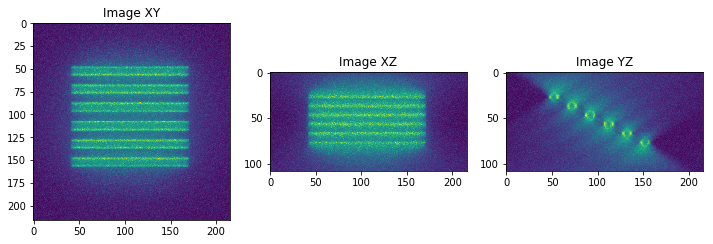

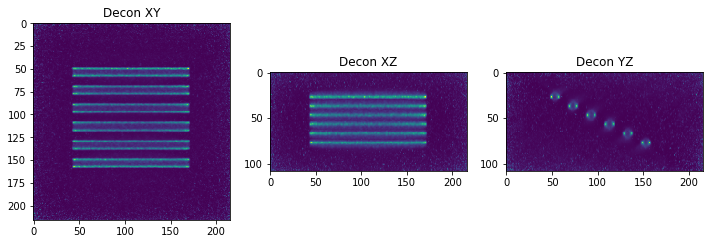

In [20]:
%matplotlib inline
plot_projections(img_arr, "Image")
plot_projections(deconvolved, "Decon")
